# Finding Data Block Nirvana - Part 2

This notebook illustrates how to use the custom fastai `ItemList` we created in part 1.  It is heavily annotated to further aid in also understanding how all the different bits in the API interact as well as what is happening at each step and why.

Please consult the [fastai docs](https://docs.fast.ai/) for installing required packages and setting up your environment to run the code below.

**Part 2** (this notebook) of the accompanying Medium article describing how to use the custom ItemList created in Part 1 can be found [here](https://medium.com/@wgilliam/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-part-2-9b23ea5d83ee).

**Part 1** of the accompanying Medium article highlighing the data block API mechanics based on my work here can be found [here](https://medium.com/@wgilliam/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

You may have to install some packages before proceeding (see below).

Also notice that we took the custom DataBlock API code introduced in part 1 and put it into `utils.py` so that it can be re-used where necessary.

In [2]:
import pdb

from fastai.tabular import *
from fastai.text import *
from fastai.text.data import _join_texts

from utils import *

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
torch.cuda.set_device(1)
print(f'using GPU: {torch.cuda.current_device()}')

using GPU: 1


In [4]:
print(f'fastai version: {__version__}') #=> I test this against 1.0.59

fastai version: 1.0.59


## Configuration

Make sure you unzip the .csv file in `joined_sample.zip` into `data/yelp_dataset` before proceeding

In [5]:
PATH=Path('data/yelp_dataset/')

PATH.mkdir(parents=True, exist_ok=True)
(PATH/'models').mkdir(parents=True, exist_ok=True)
(PATH/'tmp').mkdir(exist_ok=True)

## Utility methods

In [6]:
# None here in this notebook

## Prepare data for training/evaluation

In [7]:
train_df = pd.read_csv(PATH/'joined_sample.csv', index_col=None)

display(len(train_df))
display(train_df.head())
display(train_df.describe().T)

10000

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,user_average_stars,user_compliment_cool,user_compliment_cute,user_compliment_funny,user_compliment_hot,user_compliment_list,user_compliment_more,user_compliment_note,user_compliment_photos,user_compliment_plain,user_compliment_profile,user_compliment_writer,user_cool,user_elite,user_fans,user_friends,user_funny,user_name,user_review_count,user_useful,user_yelping_since,business_address,business_attributes,business_categories,business_city,business_hours,business_is_open,business_latitude,business_longitude,business_name,business_neighborhood,business_postal_code,business_review_count,business_stars,business_state
0,8jpIK1WHmzzbXPaK51GenQ,1,2012-08-08,3,W7wcVRiw5T8TMrmGnxPsxQ,4,I've been here at least 10 times ... I like it ... but its not my favorite. I always get the sp...,1,g6gTSnUKZIxLZPQVrFKscw,4.14,0,0,0,0,0,0,2,0,0,0,0,0,None,1,"sJEgIk45pmVEJAHQMDKi4A, xduGhZ92kLqvTGZ2-zX0hg, UKPkJvtM5ceTng8fG4Wg8A, AIVgQY1-2O8gVFevmys3_Q",0,Debbie,26,1,2011-10-25,4050 W Ray Rd,"{'Alcohol': 'none', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipste...","American (Traditional), Breakfast & Brunch, Sandwiches, Restaurants",Chandler,"{'Tuesday': '6:30-14:30', 'Wednesday': '6:30-14:30', 'Thursday': '6:30-14:30', 'Friday': '6:30-1...",0,33.320994,-111.912682,Dessie's Cafe,NaN,85226,67,3.5,AZ
1,wH4Q0y8C-lkq21yf4WWedw,0,2015-01-31,0,emypFL3PJjQBcllPZw_d5A,5,"Although I had heard of Nekter, mainly from seeing it tagged in health conscious friends' IG pos...",2,LAEJWZSvzsfWJ686VOaQig,5.00,0,0,0,0,0,0,0,0,0,0,0,1,None,2,"EFFWziYSge9vgL5QOuVodA, urMngjIG5D8Xde67j3AqSg, VLi09RsVRFlz7lizld85DQ, 59o2lrt5U1qxNys7eEsVcA, ...",1,Andrea,5,1,2013-12-24,9301 E Shea Blvd,"{'Alcohol': 'none', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipste...","Juice Bars & Smoothies, Gluten-Free, Food, Ice Cream & Frozen Yogurt, Restaurants, Acai Bowls",Scottsdale,"{'Monday': '6:30-20:0', 'Tuesday': '6:30-20:0', 'Wednesday': '6:30-20:0', 'Thursday': '6:30-20:0...",1,33.580474,-111.881062,Nekter Juice Bar,NaN,85260,59,4.0,AZ
2,cRMC2eQ9CP6ivhEY8EdaGg,1,2010-09-13,0,5X5ISEAp6HFTpMd_wlq_9w,3,Last week I met up with a highschool friend for the first time after highschool graduation for b...,1,TwilnpgwW43r9-O2AS4PDQ,3.14,14,0,14,6,1,4,22,3,64,1,9,2,"2011, 2010, 2012",12,"TkzLgJrW-OqwJ4Ws5oYBZg, CxDOIDnH8gp9KXzpBHJYXw, AVDCZrLcKlaNhpk_qWtC5g, nCqOSH2I6-k93B04FwouIA, ...",3,Marie,94,0,2010-01-25,"459 Church Street, 2nd Floor","{'Alcohol': 'none', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipste...","Mexican, Restaurants, Asian Fusion",Toronto,"{'Monday': '12:0-21:0', 'Tuesday': '12:0-21:0', 'Wednesday': '12:0-21:0', 'Thursday': '12:0-21:0...",0,43.664193,-79.380196,Chino Locos,Church-Wellesley Village,M4Y 2C5,34,3.5,ON
3,zunMkZ4U2eVojempQtLngg,1,2014-03-07,0,OGekU1U_wWgV--zL2gEgYw,4,A friend and I were driving by and decided to stop in and check out the place. Glad we did. We...,1,eITkQlKYsYqOBASP-QS0iQ,3.72,0,0,0,1,0,0,0,0,0,0,0,0,None,1,"9RBRKzif1GD03M0bIX2hMQ, PHL0ESwylh6SKdmRsMXF0g, lP5UMXZGJrvWyTKiVC8Ytg, v914os7MSHH1rw378--r5A, ...",4,Sean,69,10,2007-12-03,5830 W Bell Rd,"{'Alcohol': 'full_bar', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hi...","Sports Bars, Burgers, Nightlife, Bars, Australian, Restaurants, Sandwiches",Glendale,"{'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', 'Wednesday': '11:0-1:0', 'Thursday': '11:0-2:0', '...",0,33.639158,-112.185110,The Australian AZ,NaN,85308,26,2.5,AZ
4,1vLf-v7foAu3tJ7vAEoKdA,0,2014-11-26,1,tTe2cLFmpkLop3wKcT0Zgw,5,Our Bulldog LOVES this place and so do we! Wonderful husband and wife team that are true dog lov...,0,l3okl_UjyNdqRKAzYGdWaA,2.95,0,0,0,0,0,0,0,0,0,0,0,0,None,0,g0arZP7975-VYy6Vff0unQ,1,Jim,18,1,2014-04-27,"7000 E Shea Blvd, Ste 1360",NaN,"Pets, Pet Services, Pet Groomers, Pet Sitting",Scottsdale,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0', 'Wednes

,count,mean,std,min,25%,50%,75%,max
cool,10000.0,0.558300,1.975650,0.000000,0.000000,0.000000,0.000000,70.000000
funny,10000.0,0.534500,4.304098,0.000000,0.000000,0.000000,0.000000,388.000000
stars,10000.0,3.721300,1.455211,1.000000,3.000000,4.000000,5.000000,5.000000
useful,10000.0,1.368800,3.678959,0.000000,0.000000,0.000000,2.000000,212.000000
user_average_stars,10000.0,3.739603,0.802876,1.000000,3.400000,3.810000,4.200000,5.000000
user_compliment_cool,10000.0,37.518800,308.275809,0.000000,0.000000,0.000000,2.000000,13014.000000
user_compliment_cute,10000.0,1.695100,31.125260,0.000000,0.000000,0.000000,0.000000,2250.000000
user_compliment_funny,10000.0,37.518800,308.275809,0.000000,0.000000,0.000000,2.000000,13014.000000
user_compliment_hot,10000.0,25.273900,240.013823,0.000000,0.000000,0.000000,1.000000,9259.000000
user_compliment_list,10000.0,1.222300,27.808089,0.000000,0.000000,0.000000,0.000000,2259.000000


Define the categorical, continuous, and text column(s) here along with your dependent variable.

In [8]:
cat_cols = [
    'business_id', 
    'user_id', 
    'business_is_open', 
    'business_city', 
    'business_postal_code', 
    'business_state'
]

cont_cols = [
    'cool', 
    'funny',
    'useful',
    'user_average_stars',
    'business_stars'
]

txt_cols = ['text']

dep_var = ['stars']

In [9]:
train_df.stars.value_counts()

5    4368
4    2234
1    1457
3    1098
2     843
Name: stars, dtype: int64

## LM Fine-tuning

We fine-tune our ULMFit model against our target corpus just like we do when building a language model for future downstream text classification.

Since we are planning using the encoder only in the mixed model, we call `learn.save_encoder()` at the end of this step.

In [10]:
lm_df = pd.DataFrame(pd.concat([train_df[txt_cols]], axis=0))
lm_df[txt_cols].fillna('None', inplace=True)

data_lm = (TextList.from_df(lm_df, PATH, cols=txt_cols)
            .split_by_rand_pct()
            .label_for_lm()
            .databunch())

data_lm.save('data_lm_export.pkl')

In [11]:
data_lm = load_data(PATH, file='data_lm_export.pkl')

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [12]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.137733,3.900520,0.273574,00:23


In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.903042,3.864615,0.277776,00:29
1,3.861111,3.804670,0.284191,00:30
2,3.777481,3.752403,0.289185,00:30
3,3.693825,3.714305,0.292983,00:30
4,3.617983,3.691016,0.295456,00:30
5,3.547895,3.678040,0.296731,00:30
6,3.512510,3.669504,0.297685,00:30
7,3.470738,3.665542,0.298132,00:30
8,3.446136,3.664811,0.298344,00:30
9,3.451342,3.665334,0.298373,00:30


In [14]:
learn.predict("Our cats love this funny", n_words=10)

"Our cats love this funny , incredible show . We ate Melissa 's"

In [15]:
learn.save_encoder('lm_ft_enc')

## Build the MixedTabular Databunch

If this doesn't look familiar, read the part 1 article.

In [16]:
procs = [FillMissing, Categorify, Normalize]

In [17]:
data_cls = (MixedTabularList.from_df(train_df, cat_cols, cont_cols, txt_cols,
                                     vocab=data_lm.train_ds.vocab, procs=procs, path=PATH)
          .split_by_rand_pct(valid_pct=0.1, seed=42)
          .label_from_df(dep_var)
          .databunch(bs=32))

In [18]:
print(f'CATS:\n{data_cls.train_ds.cat_names}')
print(f'CONTS:\n{data_cls.train_ds.cont_names}')
print(f'TEXT COLS:\n{data_cls.train_ds.text_cols}')
print(f'PROCS:\n{data_cls.train_ds.procs}')

CATS:
['business_id', 'user_id', 'business_is_open', 'business_city', 'business_postal_code', 'business_state']
CONTS:
['cool', 'funny', 'useful', 'user_average_stars', 'business_stars']
TEXT COLS:
['text']
PROCS:
[<class 'fastai.tabular.transform.FillMissing'>, <class 'fastai.tabular.transform.Categorify'>, <class 'fastai.tabular.transform.Normalize'>]


In [19]:
len(data_cls.train_ds.x.vocab.itos), len(data_cls.valid_ds.x.vocab.itos)

(10736, 10736)

In [20]:
data_cls.show_batch()

business_id,user_id,business_is_open,business_city,business_postal_code,business_state,cool,funny,useful,user_average_stars,business_stars,target
pGLI8cMlay44bxYYjb4yIQ,gt4Ox6KrBwCLa0XWiSLFPg,1,Phoenix,85003,AZ,0.7044,-0.1214,0.1650,0.4980,0.3582,4
CXsnrd0x-cobsI2KpeW4HA,fF6JjBmoDfggyCX7eSogQw,1,Charlotte,28277,NC,-0.2781,-0.1214,-0.3635,-0.9182,0.3582,5
OpNrObgtHgYijZYOU0yF-Q,k0bqIdvhAnq3eV-s9YnJLQ,0,Pittsburgh,15213,PA,-0.2781,-0.1214,-0.0993,-1.4026,-0.9675,1
0k_Ax1rXz2lq6p2OThlOUQ,1OfFkW-i-mfBw0Hoon1sCw,1,Tempe,85283,AZ,-0.2781,-0.1214,-0.0993,-0.9182,-0.9675,1
Hlr62QVRX1h9Euk73gBdnA,Yjer78RnYr7OCzirgdcOaw,1,Montréal,H2X 1K3,QC,0.2132,0.0999,-0.3635,0.4980,-0.9675,4


text_data,target
"xxbos(2) xxmaj(5) we(26) visited(920) the(10) xxmaj(5) japanese(1285) xxmaj(5) friendship(9511) xxmaj(5) garden(1476) on(32) xxmaj(5) easter(7446) xxmaj(5) sunday(659) and(11) it(17) was(16) a(14) great(51) little(131) xxunk(0) in(22) the(10) desert(1514) .(9) xxmaj(5) after(104) a(14) $(90) 5(147) entrance(1455) fee(1235) and(11) buying(1192) a(14) $(90) xxunk(0) cup(854) of(18) xxmaj(5) xxunk(0) food(42) ,(12) we(26) headed(2088) into(223) the(10) garden(1476) with(27) a(14) helpful(375) map(3797) in(22) hand(724) .(9) xxmaj(5) of(18) course(466) ,(12) the(10) garden(1476) is(19) quite(296) small(205) ((54) 4(122) xxunk(0) ,(12) i(13) think(173) )(52) so(38) it(17) was(16) n't(33) that(24) we(26) would(66) have(35) gotten(1156) lost(932) without(346) the(10) map(3797) but(31) it(17) was(16) very(49) helpful(375) at(40) explaining(2608) the(10) features(3346) that(24) we(26) were(39) seeing(1167) and(11) how(146) they(30) relate(10400) to(15) traditional(1109) xxmaj(5) japanese(1285) gardens(7567) and(11) culture(3477) .(9) xxmaj(5) very(49) interesting(883) !(20) xxmaj(5) they(30) also(92) hold(1158) traditional(1109) xxmaj(5) japanese(1285) tea(383) xxunk(0) once(310) a(14) month(733) for(21) an(79) additional(1433) charge(666) .(9) xxmaj(5) keep(458) in(22) mind(622) ,(12) the(10) garden(1476) closes(4013) over(130) the(10) summer(1062) so(38) be(46) sure(170) to(15) check(270) the(10) website(1122) to(15) see(177) if(57) they(30) are(41) open(385) when(72) you(28) want(164) to(15) visit(263) .(9) xxmaj(5) overall(279) ,(12) this(29) was(16) a(14) great(51) find(218) in(22) the(10) xxup(6) phx(5671) metro(3859) and(11) we(26) will(81) be(46) back(74) to(15) visit(263) soon(572) .(9)",4
"xxbos(2) xxmaj(5) this(29) is(19) my(23) third(1211) time(63) being(209) there(48) and(11) it(17) 's(37) been(87) great(51) every(184) time(63) .(9) xxmaj(5) every(184) employee(1047) is(19) helpful(375) and(11) friendly(121) .(9) xxmaj(5) the(10) amount(532) of(18) salad(242) given(584) is(19) extremely(397) fair(860) for(21) the(10) amount(532) paid(534) .(9) xxmaj(5) the(10) salads(962) are(41) about(77) the(10) same(259) price(179) as(47) xxmaj(5) panera(5114) ,(12) but(31) way(157) better(151) .(9) xxmaj(5) you(28) get(67) to(15) build(2098) your(88) own(453) salad(242) or(75) pick(508) one(68) theirs(2671) off(142) a(14) menu(140) .(9) xxmaj(5) you(28) also(92) get(67) to(15) choose(641) the(10) amount(532) of(18) dressing(1084) on(32) your(88) salad(242) which(85) is(19) convenient(1251) .(9) xxmaj(5) if(57) you(28) go(78) around(172) lunch(208) time(63) it(17) 'll(217) probably(299) be(46) busy(300) ,(12) but(31) the(10) line(291) moves(4265) quickly(490) .(9) xxmaj(5) xxunk(0) has(112) quickly(490) become(1346) one(68) of(18) my(23) favorite(280) places(308) to(15) eat(196) .(9)",5
"xxbos(2) xxmaj(5) another(189) example(1889) of(18) bad(201) xxmaj(5) italian(743) food(42) in(22) xxmaj(5) pittsburgh(1510) .(9) xxmaj(5) other(103) reviewers(3303) have(35) used(324) ""(55) mediocre(1025) ""(55) but(31) that(24) 's(37) being(209) kind(294) .(9) xxmaj(5) the(10) food(42) is(19) sub(1742) -(43) par(1521) for(21) a(14) traditional(1109) restaurant(127) .(9) i(13) 've(99) had(36) better(151) at(40) local(535) bars(1927) that(24) a(14) ""(55) cook(913) ""(55) working(483) with(27) only(96) a(14) microwave(3161) and(11) deep(982) fryer(6433) .(9) xxmaj(5) it(17) all(53) tastes(921) pre(1573) -(43) packaged(5304) and(11) processed(3601) .(9) i(13) guess(576) the(10) xxmaj(5) xxunk(0) students(2828) like(60) it(17) for(21) the(10) price(179) and(11) convenient(1251) location(192) .(9)",1
"xxbos(2) xxmaj(5) bad(201) experience(139) .(9) i(13) tried(243) taking(602) back(74) something(211) i(13) just(64) bought(670) last(212) week(415) and(11) the(10) man(583) xxunk(0) told(203) me(50) it(17) was(16) not(34) available(671) at(40) this(29) store(264) ,(12) did(69) not(34) xxunk(0) or(75) attempt(2892) to(15) help(392) me(50) fi

## Models

In [21]:
from fastai.callbacks import hook_output
from fastai.text.learner import RNNTrainer, masked_concat_pool

I'm going to create a couple of configuration dictionaries here to make experimentation easier.  The first is for the tabular model derived from `tabular_learner` and the second is for the model returned from `text_classifier_learner`.

In [22]:
tab_layers = [200, 100]
tabular_args = {
    'metrics': accuracy, 
    'ps': [.05, .03], 
    'emb_drop': 0.3, 
    #'y_range': [1, 5.1]
}

In [23]:
bptt = 70
emb_size = 400
n_hidden = 1150
n_layers = 3

max_seq = 70*20
drop_mult = 0.5

text_args = {
    'bptt': bptt, 
    'drop_mult': drop_mult,
    'max_len': max_seq
}

This is where the fun begins!

The results are currently not all that great, and I'm not sure if how I'm using the respective tabular and text classification learner's to build my model is genius or dumb, but it does at least appear a novel way of doing it that kinda works :)

For the tabular bits, I chop off the last layer via `tab_learner.model.layers[:-1]` (this layer is the final linear with the outputs being your predicted labels).

For the text bits, after loading the fine-tuned LM encoder we chop off the `PoolingClassifier` leaving just the encoder.

The training process is rather simple here.  We pass the categorical and continuous data through the tabular model and the numericalized text through the LM encoder.  We use the concat pooling trick to produce the final output from the text model which we then concatenate with the output from the tabular model.  From there, we run the results through a couple of linear layers and return the predictions.

In [24]:
class TabularTextNN(nn.Module):
    def __init__(self, data, tab_layers, tab_args={}, text_args={}):
        super().__init__()
        
        tab_learner = tabular_learner(data, tab_layers, **tab_args)
        tab_learner.model.layers = tab_learner.model.layers[:-1]
        self.tabular_model = tab_learner.model

        text_class_learner = text_classifier_learner(data, AWD_LSTM, **text_args)
        text_class_learner.load_encoder('lm_ft_enc')
        self.text_enc_model = list(text_class_learner.model.children())[0]
        
        self.bn_concat = nn.BatchNorm1d(400*3+100)
        
        self.lin = nn.Linear(400*3+100, 50)
        self.final_lin = nn.Linear(50, data.c)
        
    def forward(self, x_cat:Tensor, x_cont:Tensor, text_input:Tuple[Tensor,Tensor]) -> Tensor:
        # grab the tabular results minus the last layer
        tab_res = self.tabular_model.forward(x_cat, x_cont)

        # grab the results of the encoder
        raw_outputs, outputs, mask = self.text_enc_model(text_input)
        text_final_rnn_output = masked_concat_pool(outputs, mask) #outputs[-1][:,-1] # => (bs, 400*3)
  
        # do the concat pooling trick with the tabular and text encoder results
        x = torch.cat([tab_res, text_final_rnn_output], dim=1)
        x = self.bn_concat(x)
        
        # run the final results though a couple of linears
        x = self.final_lin(F.relu(self.lin(x)))
        
        # return the goods
        return x, raw_outputs, outputs
    
    def reset(self):
        self.text_enc_model.reset()

## Training/evaluation

In [25]:
model = TabularTextNN(data_cls, tab_layers, tabular_args, text_args)

In [26]:
learn = None; gc.collect()
learn = Learner(data_cls, model, metrics=[accuracy])

In [27]:
learn.callbacks.append(RNNTrainer(learn, bptt))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


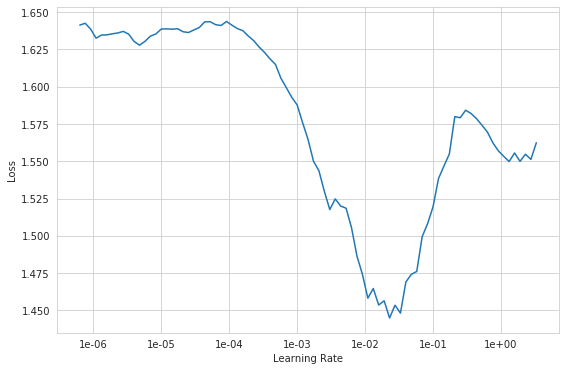

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 1e-2, wd=1e-1, pct_start=0.2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.931140,0.872102,0.606000,01:00


In [30]:
learn.unfreeze()
learn.fit_one_cycle(5, 5e-4, wd=1e-1, pct_start=0.2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.730402,0.851919,0.629000,02:24
1,0.626204,0.815977,0.636000,02:23
2,0.434229,0.876121,0.652000,02:23
3,0.313080,0.921599,0.673000,02:23
4,0.268226,0.940466,0.664000,02:24


## Review

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [32]:
interp = learn.interpret()

Confusion matrix, without normalization


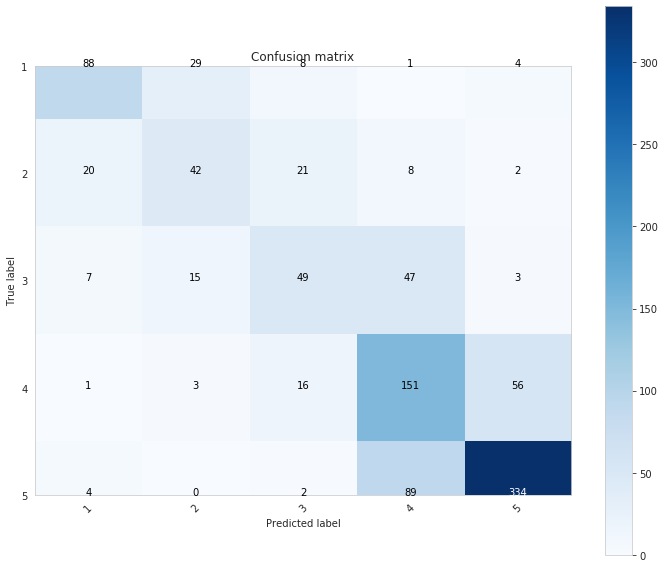

In [33]:
cm =interp.confusion_matrix()
# interp.top_losses(k=10)

plt.figure(figsize=(10,8))
plt.grid(False)
plot_confusion_matrix(cm, interp.data.train_ds.y.classes)

In [34]:
interp.top_losses(20)

torch.return_types.topk(
values=tensor([9.8797, 9.4208, 7.6544, 7.6051, 7.3600, 6.6627, 6.3072, 6.1528, 6.1402,
        6.0284, 5.8274, 5.6590, 5.5843, 5.4722, 5.3871, 5.3300, 5.2329, 5.2224,
        5.2204, 5.2200]),
indices=tensor([ 11, 263, 880, 111,  71, 718, 760, 171, 231, 762, 767, 952, 376, 902,
        794, 889, 318, 611, 246, 608]))